In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import spacy
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
embedding_dim = 50
maxlen = 64

In [37]:
def save_model(model, model_path="models/MSA_cnn_model.json", weights_path="models/MSA_cnn_model.hdf"):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weights_path)
    print("Saved model to models/MSA_cnn_model.json")

In [38]:
with open('models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
print("loaded tokenizer from models/tokenizer.pickle")
vocab_size = len(tokenizer.word_index) + 1

loaded tokenizer from models/tokenizer.pickle


In [39]:
training_df = pd.read_csv('data/moral_samples.csv')
training_df.head()

,text,moral_saliency,moral_intrinsicality,notes
0,All human beings have inherent worth.,1,3,NaN
1,It's wrong to exploit people you have power over.,1,2,NaN
2,Jeff Bezos is an evil man.,1,1,NaN
3,Human beings have a brain that resides in thei...,0,0,NaN
4,It's incorrect to assume that one plus one is ...,0,0,NaN


In [89]:
train = training_df.sample(frac=0.8)
test = training_df.drop(train.index)
print("train len: ", len(train))
print("test len: ", len(test))

train len:  80
test len:  20


In [90]:
input_train = tokenizer.texts_to_sequences(train["text"].values)
input_test = tokenizer.texts_to_sequences(test["text"].values)

In [91]:
input_train = pad_sequences(input_train, padding='post', maxlen=maxlen)
input_test = pad_sequences(input_test, padding='post', maxlen=maxlen)

In [92]:
output_train = train["moral_saliency"]
output_test = test["moral_saliency"]

In [93]:
# load json and create model
json_file = open("models/sentiment_analysis_cnn_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
gsa_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
gsa_model.load_weights("models/sentiment_analysis_cnn_model.hdf")
print("Loaded model from disk")

Loaded model from disk


In [45]:
gsa_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 64, 50)            15469100  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 61, 32)            6432      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total para

In [46]:
clipped_gsa_model = keras.Model(gsa_model.input, gsa_model.layers[-2].output)
for layer in clipped_gsa_model.layers:
    layer.trainable = False
clipped_gsa_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5_input (InputLaye (None, 64)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 64, 50)            15469100  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 61, 32)            6432      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
Total para

In [47]:
model = keras.Sequential()
model.add(clipped_gsa_model)
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Model)              (None, 16)                15476060  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 15,476,077
Trainable params: 17
Non-trainable params: 15,476,060
_________________________________________________________________


In [48]:
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [94]:
history = model.fit(input_train, output_train,
                    epochs=16,
                    verbose=True,
                    validation_data=(input_test, output_test),
                    batch_size=32)
loss, accuracy = model.evaluate(input_test, output_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
save_model(model)

Train on 80 samples, validate on 20 samples
Epoch 1/16
80/80 [==============================] - 0s 254us/step - loss: 0.7772 - acc: 0.5000 - val_loss: 0.8152 - val_acc: 0.4500
Epoch 2/16
80/80 [==============================] - 0s 215us/step - loss: 0.7448 - acc: 0.5125 - val_loss: 0.8080 - val_acc: 0.4500
Epoch 3/16
80/80 [==============================] - 0s 193us/step - loss: 0.7470 - acc: 0.5125 - val_loss: 0.7987 - val_acc: 0.4500
Epoch 4/16
80/80 [==============================] - 0s 289us/step - loss: 0.7584 - acc: 0.5125 - val_loss: 0.7870 - val_acc: 0.4500
Epoch 5/16
80/80 [==============================] - 0s 255us/step - loss: 0.7431 - acc: 0.5250 - val_loss: 0.7754 - val_acc: 0.4500
Epoch 6/16
80/80 [==============================] - 0s 326us/step - loss: 0.7514 - acc: 0.5250 - val_loss: 0.7625 - val_acc: 0.4500
Epoch 7/16
80/80 [==============================] - 0s 422us/step - loss: 0.7487 - acc: 0.5500 - val_loss: 0.7499 - val_acc: 0.4500
Epoch 8/16
80/80 [==============

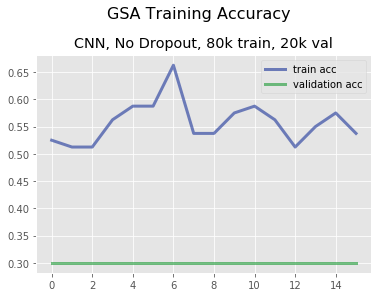

In [50]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
plt.style.use("ggplot")
plt.plot(acc, color=(0.1, 0.2, 0.6, 0.6), label="train acc", lw=3)
plt.plot(val_acc, color=(0.1, 0.6, 0.2, 0.6), label="validation acc", lw=3)
plt.suptitle("GSA Training Accuracy\n\n", fontsize=16, y=1.05)
plt.title("CNN, No Dropout, 80k train, 20k val", y=1.01)
plt.legend()
plt.savefig("graphs/GSA-CNN-ND.png")
plt.show()

In [61]:
from nlutil.nlutil import quick_corpus
from random import randint

In [76]:
science = quick_corpus("science", results=20)

Note: because Science (disambiguation) was a disambiguation page, we're not adding it to the corpus, and trying Mathematical sciences instead.
Note: because Rocket science was a disambiguation page, we're not adding it to the corpus, and trying Science fair instead.


In [78]:
religion = quick_corpus("religion", results=20)

Note: because No religion was a disambiguation page, we're not adding it to the corpus, and trying Timeline of religion instead.
Note: because No religion was a disambiguation page, we're not adding it to the corpus, and trying Religion in Africa instead.


In [79]:
data = {"text": [], "topic": []} # 0 for science, 1 for religion

In [80]:
# add science data to dict
counter = 0
while counter < len(science):
    sample_len = randint(6,20)
    sample = " ".join(science[counter:counter+sample_len])
    counter += sample_len
    data["text"].append(sample)
    data["topic"].append(0)

In [81]:
# add religion data to dict
counter = 0
while counter < len(religion):
    sample_len = randint(6,20)
    sample = " ".join(religion[counter:counter+sample_len])
    counter += sample_len
    data["text"].append(sample)
    data["topic"].append(1)

In [82]:
sci_rel_df = pd.DataFrame(data).sample(frac=1)

In [83]:
print(len(sci_rel_df))
sci_rel_df.head()

15808


,text,topic
15445,exiled in at the age of after the wars during ...,1
10549,faiths including jainism bahá í faith zoroastr...,1
13814,with a major observatory by the twentieth cent...,1
11068,folk religion have overlapping uses the latter...,1
2585,very little in the past two millennia see also...,0


In [84]:
train = sci_rel_df.sample(frac=0.8)
test = sci_rel_df.drop(train.index)
print("train len: ", len(train))
print("test len: ", len(test))

train len:  12646
test len:  3162


In [85]:
input_train = tokenizer.texts_to_sequences(train["text"].values)
input_test = tokenizer.texts_to_sequences(test["text"].values)

In [86]:
input_train = pad_sequences(input_train, padding='post', maxlen=maxlen)
input_test = pad_sequences(input_test, padding='post', maxlen=maxlen)

In [87]:
output_train = train["topic"]
output_test = test["topic"]

In [88]:
history = model.fit(input_train, output_train,
                    epochs=16,
                    verbose=True,
                    validation_data=(input_test, output_test),
                    batch_size=32)
loss, accuracy = model.evaluate(input_test, output_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
save_model(model)

Train on 12646 samples, validate on 3162 samples
Epoch 1/16
12646/12646 [==============================] - 2s 156us/step - loss: 0.5930 - acc: 0.7149 - val_loss: 0.5916 - val_acc: 0.7059
Epoch 2/16
12646/12646 [==============================] - 2s 153us/step - loss: 0.5898 - acc: 0.7140 - val_loss: 0.5909 - val_acc: 0.7059
Epoch 3/16
12646/12646 [==============================] - 2s 149us/step - loss: 0.5894 - acc: 0.7140 - val_loss: 0.5908 - val_acc: 0.7059
Epoch 4/16
12646/12646 [==============================] - 2s 149us/step - loss: 0.5914 - acc: 0.7133 - val_loss: 0.5914 - val_acc: 0.7059
Epoch 5/16
12646/12646 [==============================] - 2s 152us/step - loss: 0.5909 - acc: 0.7144 - val_loss: 0.5906 - val_acc: 0.7059
Epoch 6/16
12646/12646 [==============================] - 2s 154us/step - loss: 0.5928 - acc: 0.7141 - val_loss: 0.5923 - val_acc: 0.7059
Epoch 7/16
12646/12646 [==============================] - 2s 149us/step - loss: 0.5897 - acc: 0.7135 - val_loss: 0.5908 - v